# Оценивание моделей типа ARCH 

Одномерные ARCH модели появились в литературе с работой Engle (1982), и были вскоре обобщены в модель GARCH в работе Bollerslev (1986). Изначально их использовали для предсказания волатильности ряда инфляции, однако модели оказались релевантны и для предсказания волатильности финансовой доходности, наблюдаемой на месячных и более частых данных. Это позволяет изучать межвременное соотношение между риском и ожидаемой доходность.

Документация к пакету ARCH
http://arch.readthedocs.io/

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.mpl.rcParams['figure.figsize'] = (20, 5)
%matplotlib inline

## Загрузка данных
Загружаем данные о цене акций напрямую с Yahoo Finance при помощи пакета `pandas_datareader`. 
Пример для акций Яндекса

In [18]:
import datetime as dt
import pandas as pd
import pandas_datareader.data as pdr
import fix_yahoo_finance 
fix_yahoo_finance.pdr_override() # Yahoo changed their API some days ago, it's a temporary fix 

# download dataframe
start = dt.datetime(2011,1,1)
end = dt.datetime(2018,1,1)
data = pdr.get_data_yahoo('YNDX', start=start, end=end)

[*********************100%***********************]  1 of 1 downloaded


In [19]:
# Выберите компанию для анализа, загрузите данные о ее цене
# Постройте график цены акции

In [20]:
price = pd.read_csv('data.csv')
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2011-05-24,35.000000,42.009998,30.549999,38.840000,38.840000,70186700
2011-05-25,37.750000,37.900002,34.400002,35.000000,35.000000,11761600
2011-05-26,34.450001,35.450001,34.000000,34.770000,34.770000,4417500
2011-05-27,34.750000,35.000000,34.000000,34.450001,34.450001,2006000
2011-05-31,34.950001,35.369999,32.610001,33.450001,33.450001,3981100


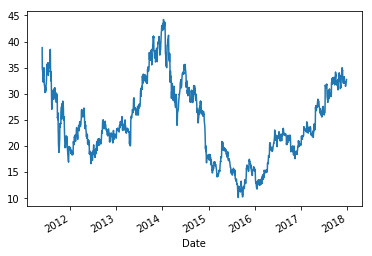

In [21]:
data['Adj Close'].plot()

## Стилизованные факты о ряде доходности


Пусть $P_t, t = 0, 1, ..., n$ — цена финансового актива в момент времени $t$. Тогда доходность актива определяется как

$$ y_t = \dfrac{P_t - P_{t-1}}{P_{t-1}} \approx \ln P_t - \ln P_{t-1} $$

Ряд $y_t$ отражает типичные «стилизованные факты», присущие финансовым данным:

- Volatility clustering — за большими изменениями доходности следуют большие изменения, за малыми — малые (видно из графиков $y_t, y_t^2$ и положительной автокорреляции $y_t^2$)
- Fat tails — экстремальные значения появляются чаще, чем при нормальном распределении (QQ-plot $y_t$ и гистограмма)
- Кроме того, в данных присутствует leverage effect (не отражено на графиках) — положительные и отрицательные изменения доходности по разному влияют на волатильность

    

In [9]:
returns = 100 * price['Adj Close'].pct_change().dropna()
squared_returns = returns ** 2

In [10]:
returns.describe()

count    1662.000000
mean        0.030626
std         2.860501
min       -14.053333
25%        -1.484234
50%        -0.034820
75%         1.578984
max        16.270396
Name: Adj Close, dtype: float64

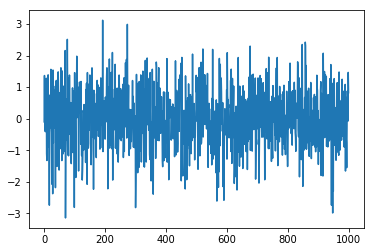

In [27]:
normal_dist = np.random.normal(size=1000)
plt.plot(normal_dist)

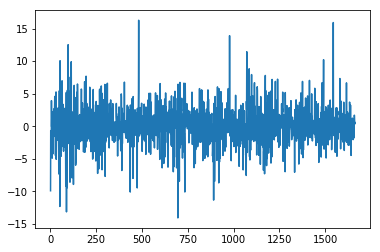

In [22]:
returns.plot()

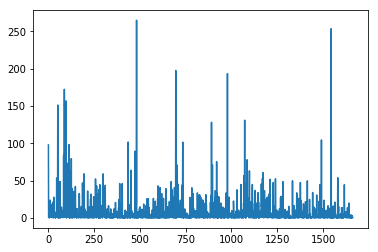

In [23]:
squared_returns.plot()

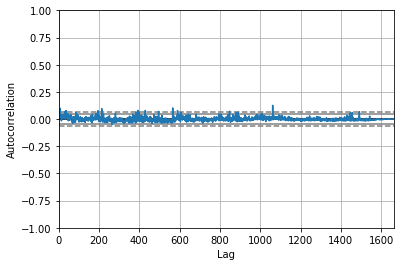

In [29]:
from pandas.plotting import autocorrelation_plot

autocorrelation_plot(squared_returns)

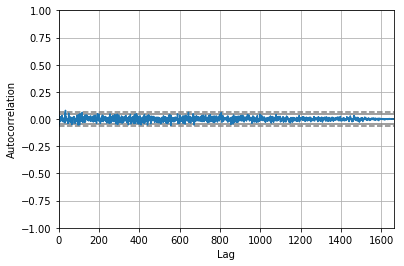

In [34]:
autocorrelation_plot(returns)

In [5]:
# Постройте график доходности, доходности^2, автокорреляционные функции доходности и доходности^2
# Постройте гистограмму распределения доходности и сравните ее с нормальным распределением

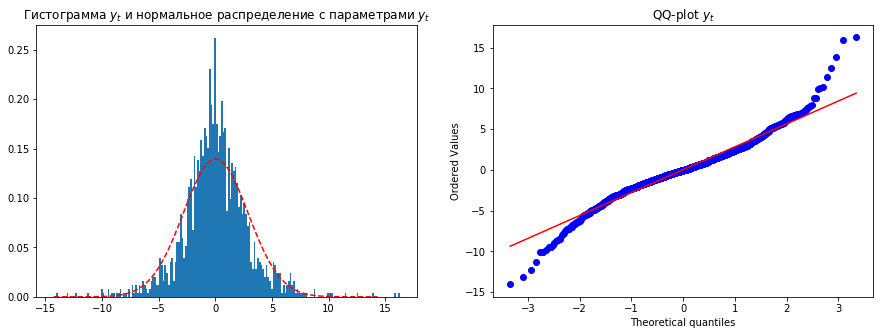

In [35]:
from scipy.stats import probplot
import matplotlib.mlab as mlab

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.title('Гистограмма $y_t$ и нормальное распределение с параметрами $y_t$')
returns.hist(bins=200, normed=True)
mu = returns.mean()
sigma = returns.std()
x = np.linspace(mu - 5*sigma, mu + 5*sigma, 100)
plt.plot(x, mlab.normpdf(x, mu, sigma), ls='--', c='red')
plt.grid()

plt.subplot(1, 2, 2)
probplot(returns, dist="norm", plot=plt)
plt.title('QQ-plot $y_t$')
plt.show()

То, что распределение доходности $y_t$ не соответствует нормальному распределению, подтверждается тестом Jarque-Bera 

In [36]:
from scipy.stats import jarque_bera

print(f'JB: {jarque_bera(returns)[0]:.5}, p-value: {jarque_bera(returns)[1]}')
print(f'Kurtosis: {returns.kurtosis():.2}') # The kurtosis of any univariate normal distribution is 3

JB: 715.3, p-value: 0.0
Kurtosis: 3.2


## Структура модели GARCH

Мы определяем модель GARCH для $y_t$ (доходность финансового актива) следующим образом:

$$ y_t - \mu_t = \epsilon_t = \sigma_t z_t $$

где 
1. $z_t, t=0,1, ...$ — ненаблюдаемые i.i.d. случайные величины с $\mathbb{E}z_t = 0, \mathbb{V}ar (z_t) = 1$

2. $\mu_t, \sigma_t$ — условное математическое ожидание и дисперсия $y_t$


### GARCH(p,q)

Наиболее часто используемая спецификация GARCH предполагает, что наилучший прогноз дисперсии будущего периода — это взвешенное значение средней дисперсии в LR (константа $\omega$), дисперсии, предсказанной для текущего периода, с учетом $q$ лагов ($\sum_{i=1}^q \beta_i \sigma^2_{t-i}$) и новой информации, поступившей в предыдущие $p$ периодов (most recent squared residual or so-called innovation series — $\sum_{i=1}^p \alpha_i \epsilon^2_{t-i}$)

$$ \sigma^2_t = \omega + \sum_{i=1}^p \alpha_i \epsilon^2_{t-i} + \sum_{i=1}^q \beta_i \sigma^2_{t-i} $$


Спецификация GARCH(p,q) достаточно хорошо описывает volatility clustering и fat tails (при правильном подборе распределения ошибок), но не отражает leverage effect (разное влияние положительных и отрицательных изменений доходности). Поэтому было создано большое количество моделей, улавливающих эту асимметрию. Например, EGARCH, GJR-GARCH, TARCH, и т.д. 


### In financial applications:
The dependent variable is the return on an asset or portfolio and the variance of the return represents the risk level of those returns. 

Many banks and other financial institutions use the concept of “Value at Risk” as a way to measure the risks faced by their portfolios. The 1% Value at Risk is defined as the number of dollars that one can be 99 percent certain exceeds any losses for the next day. Statisticians call this a 1% quantile because 1% of the outcomes are worse and 99% are better. 


## Оценивание различных моделей ARCH 

http://arch.readthedocs.io/en/latest/univariate/univariate_volatility_modeling.html


## GARCH (with a constant mean)

The simplest way to specify a model is to use the model constructor arch.arch_model which can specify most common models. The simplest invocation of arch will return a model with a constant mean, GARCH(1,1) volatility process and normally distributed errors.
### 1. Fitting the model

In [43]:
from arch import arch_model

am = arch_model(returns)
res = am.fit(disp='off')
print(res.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:              Adj Close   R-squared:                      -0.000
Mean Model:             Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                      GARCH   Log-Likelihood:               -4072.71
Distribution:                  Normal   AIC:                           8153.43
Method:            Maximum Likelihood   BIC:                           8175.09
                                        No. Observations:                 1662
Date:                Thu, Mar 01 2018   Df Residuals:                     1658
Time:                        20:17:28   Df Model:                            4
                                 Mean Model                                
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
mu             0.0676  6.602e-02      1.024      0.306 [-6.17

- Usually the GARCH coefficient $\beta_1$ is found to be around 0.9 for many daily or weekly financial time series — so our model is capable of explaining volatility clustering.

- We can show, that the closer $\alpha_1 + \beta_1$ is to one, the longer is the influence of a volatility shock. (We know that the volatility "mean reverts" to its long run level)

- If a1 + b1 > 1, the GARCH model is non-stationary and the volatility will eventually explode to infinity 

In [8]:
# Посмотрите на коеффициенты в вашей модели, выполняются ли вышеописанные факты?

### 2. Model evaluation
After a GARCH model has been fit to the data, the adequacy of the fit can be evaluated using a number of graphical and statistical diagnostics. If the GARCH model is correctly specified, then the estimated standardized residuals should behave like classical regression residuals; i.e., they should not display serial correlation, conditional heteroskedasticity or any type of nonlinear dependence. In addition, the distribution of the standardized residuals  should match the specified error distribution used in the estimation.

In [45]:
returns.index 

1      -9.886715
2      -0.657143
3      -0.920331
4      -2.902758
5      -3.587447
6       3.937984
7      -0.059666
8       2.179104
9       2.249489
10     -4.885711
11     -1.501952
12     -2.958222
13     -1.539912
14      0.861794
15     -4.208861
16      0.858940
17      0.917124
18     -1.590390
19      2.671501
20     -1.349181
21      1.497887
22      1.219118
23      3.011097
24      4.584622
25      2.324204
26      2.098905
27      0.506902
28     -4.483046
29     -0.469346
30      0.648400
          ...   
1633    3.713195
1634    2.438262
1635    1.566737
1636    1.690893
1637   -1.108509
1638    3.244832
1639   -1.628571
1640    0.174272
1641   -4.465065
1642    0.485584
1643   -1.751743
1644   -1.537043
1645    1.061505
1646    0.772320
1647    1.226245
1648   -0.393704
1649    1.216181
1650   -1.201568
1651   -0.516868
1652   -2.047683
1653    0.000000
1654    0.842437
1655   -0.185650
1656   -0.774954
1657   -1.780684
1658    0.699742
1659    1.705625
1660    0.7763

The model will be estimated using the first 7 years to estimate parameters and then forecasts will be produced for the final year.

In [46]:
# split_date = dt.datetime(2017,1,1)
am = arch_model(returns)
res = am.fit(last_obs=1500, disp='off')

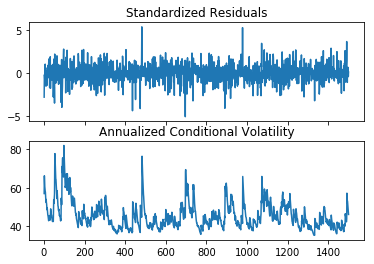

In [47]:
fig = res.plot(annualize='D')

In [ ]:
forecasts = res.forecast(horizon=5, start=split_date) # horizon — the maximum horizon to produce forecasts.
forecasts.variance.tail()

We can quickly visualize the standardized residuals and conditional volatility.

In [11]:
# Постройте график стандартизированных остатков и условной волатильности,
# сравните распределение остатков с белым шумом
# hint: нужные графики можно построить с помощью пакета arch

Any call to forecast() returns a ARCHModelForecast object with has 3 core attributes:

- mean - The forecast conditional mean.
- variance - The forecast conditional variance.
- residual_variance - The forecast conditional variance of residuals. This will differ from variance whenever the model has dynamics (e.g. an AR model) for horizons larger than 1.

In [12]:
# Постройте прогноз для тех данных, на которых вы не обучались

In [13]:
# Постройте графики спрогнозированного вами среднего и дисперсии

### 3. Model selection

An important practical problem is the determination of the ARCH order p and the GARCH order q for a particular series. Since GARCH models can be treated as ARMA models for squared residuals, traditional model selection criteria such as the Akaike information criterion (AIC) and the Bayesian information criterion (BIC) can be used for selecting models.

For daily returns, if attention is restricted to pure ARCH(p) models it is typically found that large values of p are selected by AIC and BIC. For GARCH(p,q) models, those with p,q ≤ 2 are typically selected by AIC and BIC. Low order GARCH(p,q) models are generally preferred to a high order ARCH(p) for reasons of parsimony and better numerical stability of estimation (high order GARCH(p, q) processes often have many local maxima and minima). For many applications, it is hard to beat the simple GARCH(1,1) model.

#### Remark — AIC, BIC
When fitting models, it is possible to increase the likelihood by adding parameters, but doing so may result in overfitting. Both BIC and AIC attempt to resolve this problem by introducing a penalty term for the number of parameters in the model; the penalty term is larger in BIC than in AIC.

Given a set of candidate models for the data, the preferred model is the one with the minimum AIC (BIC) value.

## Other model specifications

Models can also be systematically assembled from the three model components:

#### 1. Mean model 

http://arch.readthedocs.io/en/latest/univariate/mean.html#

All ARCH models start by specifying a mean model. Some examples:
- Zero mean

$$ y_t = \epsilon_t $$

- Constant mean

$$ y_t = \mu + \epsilon_t $$

- Autoregressive model with optional exogenous regressors 

$$ y_t = \mu + \sum_{i=1}^p \phi_i y_{t-i} + \gamma^T x_t + \varepsilon_t $$

- Exogenous regressors only

#### 2. Vol model — volatility  process

http://arch.readthedocs.io/en/latest/univariate/volatility.html

A volatility process is added to a mean model to capture time-varying volatility.

- Constant volatility process — model has the same variance in all periods
- GARCH and related model estimation:
    - ARCH(p)
    - GARCH(p,q)
    - GJR-GARCH(p,o,q)
    - AVARCH(p)
    - AVGARCH(p,q)
    - TARCH(p,o,q)
    - Models with arbitrary, pre-specified powers

where 
- p — Order of the symmetric innovation
- o – Order of the asymmetric innovation
- q – Order of the lagged (transformed) conditional variance

#### 3. Distribution of $z_t$
http://arch.readthedocs.io/en/latest/univariate/distribution.html

In [14]:
# Задайте модель с произвольным распределением среднего, остатков, количеством лагов
# Обучите ее, посмотрите на стандартные остатки, прогноз для среднего и волатильности

## Multivariate GARCH

When hopping from univariate volatility forecasts to multivariate volatility forecast, we need to understand that now we have to forecast not only the univariate volatility element, which we already know how to do, but also the covariance elements. 

The estimation will be implemented in R